In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10

In [2]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet50 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Loading the CIFAR-10 dataset
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(cifar10_dataset))
val_size = len(cifar10_dataset) - train_size
train_dataset, val_dataset = random_split(cifar10_dataset, [train_size, val_size])

#Dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:01<00:00, 99.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Teacher training

In [3]:
# Define validate function
def validate(model, val_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100. * correct / total
    return val_accuracy

# Define train function
def train(model, train_loader, val_loader, epochs, learning_rate, device, name_model = "best_model.pth"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)
    best_val_accuracy = 0.0
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Add tqdm progress bar for the training loop
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
        for i, (images, labels) in train_progress:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * correct / total
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation loop
        val_accuracy = validate(model, val_loader, device)
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), name_model)
            print("Best model saved.")

    return model, best_val_accuracy



## 1, Training the Teacher Model

In [4]:
# Load model
teacher_model = models.resnet50(pretrained=True)
num_features = teacher_model.fc.in_features
# Adjust for CIFAR-10
teacher_model.fc = nn.Linear(num_features, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


In [6]:
# Define parameters
num_epochs = 10
learning_rate = 0.0001

print("Training the teacher model-ResNet50...")
start = time.time()
teacher_model, best_teacher_acc = train(
    teacher_model,
    train_loader,
    val_loader,
    num_epochs,
    learning_rate,
    device,
    "best_trained_teacher_model.pth"
)
end = time.time()
print("Time of training : ", end - start)

Training the teacher model-ResNet50...


Epoch 1/10: 100%|██████████| 313/313 [00:57<00:00,  5.44it/s]

Epoch 1, Loss: 0.1376, Train Accuracy: 95.46%


Validation Accuracy: 94.49%
Best model saved.


Epoch 2/10: 100%|██████████| 313/313 [00:56<00:00,  5.58it/s]

Epoch 2, Loss: 0.1788, Train Accuracy: 94.11%


Validation Accuracy: 94.31%


Epoch 3/10: 100%|██████████| 313/313 [00:56<00:00,  5.57it/s]

Epoch 3, Loss: 0.0902, Train Accuracy: 96.94%


Validation Accuracy: 94.17%


Epoch 4/10: 100%|██████████| 313/313 [00:56<00:00,  5.57it/s]

Epoch 4, Loss: 0.0617, Train Accuracy: 97.89%


Validation Accuracy: 93.92%


Epoch 5/10: 100%|██████████| 313/313 [00:56<00:00,  5.57it/s]

Epoch 5, Loss: 0.0624, Train Accuracy: 97.92%


Validation Accuracy: 93.11%


Epoch 6/10: 100%|██████████| 313/313 [00:56<00:00,  5.56it/s]

Epoch 6, Loss: 0.0412, Train Accuracy: 98.61%


Validation Accuracy: 94.16%


Epoch 7/10: 100%|██████████| 313/313 [00:56<00:00,  5.57it/s]

Epoch 7, Loss: 0.0481, Train Accuracy: 98.36%


Validation Accuracy: 92.86%


Epoch 8/10: 100%|██████████| 313/313 [00:56<00:00,  5.57it/s]

Epoch 8, Loss: 0.0432, Train Accuracy: 98.51%


Validation Accuracy: 93.38%


Epoch 9/10: 100%|██████████| 313/313 [00:56<00:00,  5.58it/s]

Epoch 9, Loss: 0.0337, Train Accuracy: 98.81%


Validation Accuracy: 94.76%
Best model saved.


Epoch 10/10: 100%|██████████| 313/313 [00:56<00:00,  5.57it/s]

Epoch 10, Loss: 0.0329, Train Accuracy: 98.91%


Validation Accuracy: 93.09%
Time of training :  656.8853275775909


In [12]:
# Evaluation on test set
teacher_model.load_state_dict(torch.load("best_trained_teacher_model.pth"))
test_accuracy = validate(teacher_model, test_loader, device)
print(f"Test Accuracy of Teacher Model: {test_accuracy:.2f}%")

<ipython-input-12-419830f85506>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("best_trained_teacher_model.pth"))


Test Accuracy of Teacher Model: 94.26%


In [8]:
# Calculate the number of parameters
num_parameters = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
print(f"Number of parameters of Teacher Model: {num_parameters}")

Number of parameters of Teacher Model: 23528522


# Strategy 1: Knowledge distillation using a pre-trained Student

## 2, Train the student network (pre-trained on ImageNet)

In [12]:
# Load pre-trained ResNet18 (Student Model)
student_model = models.resnet18(pretrained=True)
num_features = student_model.fc.in_features
student_model.fc = nn.Linear(num_features, 10)

In [23]:
num_epochs = 10
learning_rate = 0.0001
start = time.time()

print("Training the student model - ResNet18...")
trained_student, best_student_acc = train(
    student_model,
    train_loader,
    val_loader,
    num_epochs,
    learning_rate,
    device,
    "best_trained_student_model.pth"
)

end = time.time()
print("Time of training : ",end - start)

Training the student model - ResNet18...


Epoch 1/10: 100%|██████████| 313/313 [00:35<00:00,  8.91it/s]

Epoch 1, Loss: 0.1253, Train Accuracy: 95.74%


Validation Accuracy: 93.68%
Best model saved.


Epoch 2/10: 100%|██████████| 313/313 [00:35<00:00,  8.92it/s]

Epoch 2, Loss: 0.1232, Train Accuracy: 95.69%


Validation Accuracy: 92.88%


Epoch 3/10: 100%|██████████| 313/313 [00:35<00:00,  8.78it/s]

Epoch 3, Loss: 0.0670, Train Accuracy: 97.67%


Validation Accuracy: 92.61%


Epoch 4/10: 100%|██████████| 313/313 [00:35<00:00,  8.91it/s]

Epoch 4, Loss: 0.0401, Train Accuracy: 98.57%


Validation Accuracy: 94.30%
Best model saved.


Epoch 5/10: 100%|██████████| 313/313 [00:34<00:00,  8.96it/s]

Epoch 5, Loss: 0.0363, Train Accuracy: 98.73%


Validation Accuracy: 93.38%


Epoch 6/10: 100%|██████████| 313/313 [00:34<00:00,  9.04it/s]

Epoch 6, Loss: 0.0303, Train Accuracy: 98.92%


Validation Accuracy: 93.59%


Epoch 7/10: 100%|██████████| 313/313 [00:34<00:00,  9.01it/s]

Epoch 7, Loss: 0.0274, Train Accuracy: 99.00%


Validation Accuracy: 93.67%


Epoch 8/10: 100%|██████████| 313/313 [00:34<00:00,  8.99it/s]

Epoch 8, Loss: 0.0244, Train Accuracy: 99.23%


Validation Accuracy: 91.39%


Epoch 9/10: 100%|██████████| 313/313 [00:40<00:00,  7.80it/s]

Epoch 9, Loss: 0.0274, Train Accuracy: 99.04%


Validation Accuracy: 94.31%
Best model saved.


Epoch 10/10: 100%|██████████| 313/313 [00:34<00:00,  9.01it/s]

Epoch 10, Loss: 0.0182, Train Accuracy: 99.45%


Validation Accuracy: 93.50%
Time of training :  446.16530203819275


In [14]:
# Evaluation on test set
test_accuracy = validate(trained_student, test_loader, device)
print(f"Test Accuracy of Student Model: {test_accuracy:.2f}%")

# Calculate number of parameters
num_parameters = sum(p.numel() for p in trained_student.parameters() if p.requires_grad)
print(f"Number of parameters of Student Model: {num_parameters}")

Test Accuracy of Student Model: 92.95%
Number of parameters of Student Model: 11181642


## 3, Using knowledge distillation at scores levels

In [19]:
# Knowledge Distillation Loss
class DistillationLoss(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.5, beta = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha # Coefficient for hard loss
        self.beta = beta # Coefficient for soft loss
        # Hard target loss
        self.criterion_ce = nn.CrossEntropyLoss()

        # Soft target loss
        self.criterion_kl = nn.KLDivLoss(reduction="batchmean")

    def forward(self, student_logits, teacher_logits, labels):
        teacher_probs = torch.softmax(teacher_logits / self.temperature, dim=1)
        student_probs = torch.log_softmax(student_logits / self.temperature, dim=1)
        # Distillation loss
        distillation_loss = self.criterion_kl(student_probs, teacher_probs) * (self.temperature ** 2)
        # Cross-entropy loss
        ce_loss = self.criterion_ce(student_logits, labels)
        # Weighted combination
        return self.alpha * ce_loss + self.beta * distillation_loss

# Initialize distillation loss
distillation_loss_fn = DistillationLoss(temperature=2.5, alpha=0.5, beta = 0.5)

In [20]:
# Training student under teacher supervision
def train_with_distillation(student_model, teacher_model, train_loader, val_loader, epochs, learning_rate, device):
  optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)
  student_model = student_model.to(device)
  teacher_model = teacher_model.to(device)

  # Freeze teacher parameters
  for param in teacher_model.parameters():
      param.requires_grad = False

  student_model.train()
  best_val_accuracy = 0.0
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Add tqdm progress bar for the training loop
    train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
    for i, (images, labels) in train_progress:
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      student_logits = student_model(images)
      with torch.no_grad():
        teacher_logits = teacher_model(images)

      # Compute distillation loss
      loss = distillation_loss_fn(student_logits, teacher_logits, labels)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = student_logits.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

      train_progress.set_postfix(loss=loss.item())

    train_accuracy = 100. * correct / total
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation loop
    val_accuracy = validate(student_model, val_loader, device)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save the best student model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      torch.save(student_model.state_dict(), "best_distilled_student_model.pth")
      print("Best distilled student model saved.")

  return student_model, best_val_accuracy

In [24]:
# Load pre-trained ResNet18 (Student Model)
student_model = models.resnet18(pretrained=True)
num_features = student_model.fc.in_features
student_model.fc = nn.Linear(num_features, 10)

# Parameters
num_epochs = 10
learning_rate = 0.0001

print("Training the student model with knowledge distillation...")
start = time.time()
trained_student_with_kd, best_kd_acc = train_with_distillation(
    student_model,
    teacher_model,
    train_loader,
    val_loader,
    epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)
end = time.time()
print("Time of traning :", end - start)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training the student model with knowledge distillation...


Epoch 1/10: 100%|██████████| 313/313 [00:42<00:00,  7.36it/s, loss=0.529]

Epoch 1, Loss: 1.3162, Train Accuracy: 86.90%


Validation Accuracy: 92.65%
Best distilled student model saved.


Epoch 2/10: 100%|██████████| 313/313 [00:42<00:00,  7.42it/s, loss=0.616]

Epoch 2, Loss: 0.4559, Train Accuracy: 94.11%


Validation Accuracy: 92.35%


Epoch 3/10: 100%|██████████| 313/313 [00:42<00:00,  7.40it/s, loss=0.173]

Epoch 3, Loss: 0.2246, Train Accuracy: 97.38%


Validation Accuracy: 94.02%
Best distilled student model saved.


Epoch 4/10: 100%|██████████| 313/313 [00:42<00:00,  7.41it/s, loss=0.107]

Epoch 4, Loss: 0.1489, Train Accuracy: 98.56%


Validation Accuracy: 94.11%
Best distilled student model saved.


Epoch 5/10: 100%|██████████| 313/313 [00:42<00:00,  7.45it/s, loss=0.112]

Epoch 5, Loss: 0.1074, Train Accuracy: 99.25%


Validation Accuracy: 94.48%
Best distilled student model saved.


Epoch 6/10: 100%|██████████| 313/313 [00:42<00:00,  7.42it/s, loss=0.0652]

Epoch 6, Loss: 0.0991, Train Accuracy: 99.35%


Validation Accuracy: 94.39%


Epoch 7/10: 100%|██████████| 313/313 [00:42<00:00,  7.42it/s, loss=0.184]

Epoch 7, Loss: 0.0958, Train Accuracy: 99.31%


Validation Accuracy: 94.34%


Epoch 8/10: 100%|██████████| 313/313 [00:42<00:00,  7.40it/s, loss=0.0561]

Epoch 8, Loss: 0.0886, Train Accuracy: 99.40%


Validation Accuracy: 93.71%


Epoch 9/10: 100%|██████████| 313/313 [00:42<00:00,  7.39it/s, loss=0.0674]

Epoch 9, Loss: 0.0787, Train Accuracy: 99.45%


Validation Accuracy: 94.15%


Epoch 10/10: 100%|██████████| 313/313 [00:42<00:00,  7.39it/s, loss=0.0947]

Epoch 10, Loss: 0.0835, Train Accuracy: 99.32%


Validation Accuracy: 94.03%
Time of traning : 512.326051235199


In [25]:
# Test the distilled student model
# trained_student_with_kd.load_state_dict(torch.load("best_distilled_student_model.pth"))
trained_student_with_kd.eval()
test_accuracy = validate(trained_student_with_kd, test_loader, device)
print(f"Test Accuracy of Distilled Student Model: {test_accuracy:.2f}%")

Test Accuracy of Distilled Student Model: 93.88%


## 4, Using knowledge distillation at both the scores and feature map levels.

In [9]:
# Feature Map Distillation Hook
def get_intermediate_outputs(model, layer_name):
    """Registers a hook to capture intermediate feature maps."""
    outputs = {}

    def hook(module, input, output):
        outputs["features"] = output

    layer = dict([*model.named_modules()])[layer_name]
    layer.register_forward_hook(hook)
    return outputs

# Updated Distillation Loss Class
class DistillationLossWithFeatures(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.5, beta=0.5):
        """
        Distillation loss combining soft targets, hard targets, and feature maps.

        Args:
            temperature: Temperature for softmax scaling.
            alpha: Weight for distillation loss from soft targets.
            beta: Weight for feature map alignment loss.
        """
        super(DistillationLossWithFeatures, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.beta = beta
        self.criterion_ce = nn.CrossEntropyLoss()  # Hard target loss
        self.criterion_kl = nn.KLDivLoss(reduction="batchmean")  # Soft target loss
        self.criterion_mse = nn.MSELoss()  # Feature map alignment loss

    def forward(self, student_logits, teacher_logits, labels, student_features, teacher_features):
        # Soft target distillation loss
        teacher_probs = torch.softmax(teacher_logits / self.temperature, dim=1)
        student_probs = torch.log_softmax(student_logits / self.temperature, dim=1)
        distillation_loss = self.criterion_kl(student_probs, teacher_probs) * (self.temperature ** 2)

        # Hard target cross-entropy loss
        ce_loss = self.criterion_ce(student_logits, labels)

        # Align teacher features to match student features
        if teacher_features.shape != student_features.shape:
          teacher_channels = teacher_features.shape[1]
          student_channels = student_features.shape[1]

          # Convolution layer to align teacher channels to student channels
          channel_projector = nn.Conv2d(teacher_channels, student_channels, kernel_size=1, stride=1, bias=False).to(device)
          teacher_features = channel_projector(teacher_features)

        # Feature map alignment loss
        feature_loss = self.criterion_mse(student_features, teacher_features)

        # Weighted combination
        return self.alpha * distillation_loss + (1 - self.alpha) * ce_loss + self.beta * feature_loss

In [10]:
def train_with_feature_distillation(student_model, teacher_model, train_loader, val_loader, epochs, learning_rate, device, teacher_layer, student_layer):
    """
    Train the student model using both scores and feature map knowledge distillation.
    """
    optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)
    student_model = student_model.to(device)
    teacher_model = teacher_model.to(device)

    # Freeze teacher parameters
    for param in teacher_model.parameters():
        param.requires_grad = False

    # Set up hooks for feature map extraction
    teacher_outputs = get_intermediate_outputs(teacher_model, teacher_layer)
    student_outputs = get_intermediate_outputs(student_model, student_layer)

    distillation_loss_fn = DistillationLossWithFeatures(temperature=3.0, alpha=0.5, beta=0.5)
    best_val_accuracy = 0.0

    for epoch in range(epochs):
        student_model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (images, labels) in train_progress:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            student_logits = student_model(images)
            with torch.no_grad():
                teacher_logits = teacher_model(images)

            # Extract feature maps
            student_features = student_outputs["features"]
            teacher_features = teacher_outputs["features"]

            # Compute distillation loss
            loss = distillation_loss_fn(student_logits, teacher_logits, labels, student_features, teacher_features)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = student_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            train_progress.set_postfix(loss=loss.item())

        train_accuracy = 100. * correct / total
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation loop
        val_accuracy = validate(student_model, val_loader, device)
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

        # Save the best student model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(student_model.state_dict(), "best_student_model_features_map.pth")
            print("Best distilled student model with features saved.")

    return student_model, best_val_accuracy

In [13]:
# Load pre-trained ResNet18 (Student Model)
student_model = models.resnet18(pretrained=True)
num_features = student_model.fc.in_features
student_model.fc = nn.Linear(num_features, 10)

# Specify layers for feature extraction
teacher_layer = "layer4"  # Last block of ResNet50
student_layer = "layer4"  # Last block of ResNet18

num_epochs = 10
learning_rate = 0.0001

# Train the student model with both score and feature map distillation
print("Training the student model with both scores and feature Maps...")
start = time.time()
feature_map_student_model, best_kd_acc = train_with_feature_distillation(
    student_model,
    teacher_model,
    train_loader,
    val_loader,
    epochs=num_epochs,
    learning_rate=learning_rate,
    device=device,
    teacher_layer=teacher_layer,
    student_layer=student_layer
)
end = time.time()
print("Time of training : ", end-start)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


Training the student model with both scores and feature Maps...


Epoch 1/10: 100%|██████████| 313/313 [00:43<00:00,  7.19it/s, loss=2.31]

Epoch 1, Loss: 3.4015, Train Accuracy: 86.69%


Validation Accuracy: 93.00%
Best distilled student model with features saved.


Epoch 2/10: 100%|██████████| 313/313 [00:43<00:00,  7.21it/s, loss=1.61]

Epoch 2, Loss: 1.6853, Train Accuracy: 96.33%


Validation Accuracy: 94.19%
Best distilled student model with features saved.


Epoch 3/10: 100%|██████████| 313/313 [00:43<00:00,  7.23it/s, loss=1.18]

Epoch 3, Loss: 1.2507, Train Accuracy: 98.52%


Validation Accuracy: 94.78%
Best distilled student model with features saved.


Epoch 4/10: 100%|██████████| 313/313 [00:43<00:00,  7.23it/s, loss=0.999]

Epoch 4, Loss: 1.0431, Train Accuracy: 99.11%


Validation Accuracy: 95.21%
Best distilled student model with features saved.


Epoch 5/10: 100%|██████████| 313/313 [00:43<00:00,  7.24it/s, loss=0.875]

Epoch 5, Loss: 0.9288, Train Accuracy: 99.22%


Validation Accuracy: 95.08%


Epoch 6/10: 100%|██████████| 313/313 [00:43<00:00,  7.24it/s, loss=0.95]

Epoch 6, Loss: 0.8533, Train Accuracy: 99.24%


Validation Accuracy: 95.19%


Epoch 7/10: 100%|██████████| 313/313 [00:43<00:00,  7.25it/s, loss=0.878]

Epoch 7, Loss: 0.8040, Train Accuracy: 99.28%


Validation Accuracy: 94.86%


Epoch 8/10: 100%|██████████| 313/313 [00:43<00:00,  7.23it/s, loss=0.855]

Epoch 8, Loss: 0.7604, Train Accuracy: 99.24%


Validation Accuracy: 95.32%
Best distilled student model with features saved.


Epoch 9/10: 100%|██████████| 313/313 [00:43<00:00,  7.24it/s, loss=0.747]

Epoch 9, Loss: 0.7301, Train Accuracy: 99.22%


Validation Accuracy: 94.38%


Epoch 10/10: 100%|██████████| 313/313 [00:43<00:00,  7.24it/s, loss=0.663]

Epoch 10, Loss: 0.6982, Train Accuracy: 99.26%


Validation Accuracy: 94.80%
Time of training :  522.886271238327


In [14]:
test_accuracy = validate(feature_map_student_model, test_loader, device)
print(f"Test Accuracy of distilled student model with features map loss level: {test_accuracy:.2f}%")

Test Accuracy of distilled student model with features map loss level: 94.16%


# Strategy 2: Knowledge distillation using a no pre-trained Student

## 5, Train the student network

In [30]:
# Load ResNet18 without pretraining
student_model = models.resnet18(pretrained=False)
num_features = student_model.fc.in_features
student_model.fc = nn.Linear(num_features, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [31]:
num_epochs = 10
learning_rate = 0.0001

# Training the student model from scratch
print("Training the student model from scratch...")
start = time.time()
trained_student, best_student_acc = train(
    student_model,
    train_loader,
    val_loader,
    epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)
end = time.time()
print("Time of traing : ", end-start)

Training the student model from scratch...


Epoch 1/10: 100%|██████████| 313/313 [00:34<00:00,  9.01it/s]

Epoch 1, Loss: 1.3930, Train Accuracy: 49.04%


Validation Accuracy: 56.48%
Best model saved.


Epoch 2/10: 100%|██████████| 313/313 [00:34<00:00,  9.07it/s]

Epoch 2, Loss: 1.3606, Train Accuracy: 50.55%


Validation Accuracy: 58.92%
Best model saved.


Epoch 3/10: 100%|██████████| 313/313 [00:35<00:00,  8.83it/s]

Epoch 3, Loss: 1.0251, Train Accuracy: 63.19%


Validation Accuracy: 64.02%
Best model saved.


Epoch 4/10: 100%|██████████| 313/313 [00:35<00:00,  8.93it/s]

Epoch 4, Loss: 0.8976, Train Accuracy: 67.92%


Validation Accuracy: 68.43%
Best model saved.


Epoch 5/10: 100%|██████████| 313/313 [00:35<00:00,  8.86it/s]

Epoch 5, Loss: 0.7887, Train Accuracy: 72.00%


Validation Accuracy: 71.65%
Best model saved.


Epoch 6/10: 100%|██████████| 313/313 [00:34<00:00,  8.94it/s]

Epoch 6, Loss: 0.6945, Train Accuracy: 75.48%


Validation Accuracy: 73.80%
Best model saved.


Epoch 7/10: 100%|██████████| 313/313 [00:34<00:00,  9.01it/s]

Epoch 7, Loss: 0.6073, Train Accuracy: 78.74%


Validation Accuracy: 74.27%
Best model saved.


Epoch 8/10: 100%|██████████| 313/313 [00:34<00:00,  9.03it/s]

Epoch 8, Loss: 0.5238, Train Accuracy: 81.56%


Validation Accuracy: 75.86%
Best model saved.


Epoch 9/10: 100%|██████████| 313/313 [00:34<00:00,  9.02it/s]

Epoch 9, Loss: 0.4326, Train Accuracy: 84.84%


Validation Accuracy: 77.20%
Best model saved.


Epoch 10/10: 100%|██████████| 313/313 [00:34<00:00,  8.97it/s]

Epoch 10, Loss: 0.3674, Train Accuracy: 87.14%


Validation Accuracy: 77.27%
Best model saved.
Time of traing :  439.61183977127075


In [32]:
test_accuracy = validate(trained_student, test_loader, device)
print(f"Test Accuracy of Student Model: {test_accuracy:.2f}%")

Test Accuracy of Student Model: 76.94%


## 6, Using knowledge distillation at the scores level

In [33]:
# Initialize the non-pretrained student model
student_model_no_pretrain = models.resnet18(pretrained=False)
num_features = student_model_no_pretrain.fc.in_features
student_model_no_pretrain.fc = nn.Linear(num_features, 10)

# Freeze the teacher model parameters
for param in teacher_model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [35]:
# Train the student network under teacher supervision (scores level)
# Re-use train_with_distillation function defined in section 3
print("Training non-pretrained student model with knowledge distillation (scores Level)...")
start = time.time()
trained_student_no_pretrain_kd, best_student_no_pretrain_kd_acc = train_with_distillation(
    student_model=student_model_no_pretrain,
    teacher_model=teacher_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)
end = time.time()
print("Time of training : ", end - start)

Training non-pretrained student model with knowledge distillation (scores Level)...


Epoch 1/10: 100%|██████████| 313/313 [00:42<00:00,  7.36it/s, loss=3.61]

Epoch 1, Loss: 4.1931, Train Accuracy: 52.24%


Validation Accuracy: 51.77%
Best distilled student model saved.


Epoch 2/10: 100%|██████████| 313/313 [00:42<00:00,  7.35it/s, loss=4.77]

Epoch 2, Loss: 5.2425, Train Accuracy: 40.34%


Validation Accuracy: 51.01%


Epoch 3/10: 100%|██████████| 313/313 [00:42<00:00,  7.34it/s, loss=4.03]

Epoch 3, Loss: 3.7436, Train Accuracy: 56.66%


Validation Accuracy: 62.01%
Best distilled student model saved.


Epoch 4/10: 100%|██████████| 313/313 [00:42<00:00,  7.37it/s, loss=3.6]

Epoch 4, Loss: 3.1563, Train Accuracy: 63.02%


Validation Accuracy: 65.45%
Best distilled student model saved.


Epoch 5/10: 100%|██████████| 313/313 [00:42<00:00,  7.38it/s, loss=2.58]

Epoch 5, Loss: 2.8126, Train Accuracy: 66.88%


Validation Accuracy: 58.58%


Epoch 6/10: 100%|██████████| 313/313 [00:42<00:00,  7.33it/s, loss=2.77]

Epoch 6, Loss: 2.5181, Train Accuracy: 70.07%


Validation Accuracy: 69.39%
Best distilled student model saved.


Epoch 7/10: 100%|██████████| 313/313 [00:42<00:00,  7.37it/s, loss=3.02]

Epoch 7, Loss: 2.2176, Train Accuracy: 73.28%


Validation Accuracy: 72.21%
Best distilled student model saved.


Epoch 8/10: 100%|██████████| 313/313 [00:42<00:00,  7.38it/s, loss=1.83]

Epoch 8, Loss: 2.0353, Train Accuracy: 75.18%


Validation Accuracy: 73.53%
Best distilled student model saved.


Epoch 9/10: 100%|██████████| 313/313 [00:42<00:00,  7.39it/s, loss=2.39]

Epoch 9, Loss: 1.8398, Train Accuracy: 77.67%


Validation Accuracy: 74.17%
Best distilled student model saved.


Epoch 10/10: 100%|██████████| 313/313 [00:42<00:00,  7.40it/s, loss=1.18]

Epoch 10, Loss: 1.6202, Train Accuracy: 80.00%


Validation Accuracy: 75.48%
Best distilled student model saved.
Time of training :  515.6589615345001


In [36]:
# Test the distilled student model
trained_student_no_pretrain_kd.load_state_dict(torch.load("best_distilled_student_model.pth"))
trained_student_no_pretrain_kd.eval()
test_accuracy = validate(trained_student_no_pretrain_kd, test_loader, device)
print(f"Test accuracy of distilled student model: {test_accuracy:.2f}%")

<ipython-input-36-87ee59c5d4e3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_student_no_pretrain_kd.load_state_dict(torch.load("best_distilled_student_model.pth"

Test accuracy of distilled student model: 74.50%


## 7, Using knowledge distillation at both the scores and feature map levels

In [37]:
# Ensure the teacher model is frozen
for param in teacher_model.parameters():
    param.requires_grad = False

# Initialize the non-pretrained student model
student_model_no_pretrain = models.resnet18(pretrained=False)
num_features = student_model_no_pretrain.fc.in_features
student_model_no_pretrain.fc = nn.Linear(num_features, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [38]:
# Specify layers for feature extraction
teacher_layer = "layer4"  # Last block of ResNet50
student_layer = "layer4"  # Last block of ResNet18

In [39]:
print("Training non-pretrained student model with both scores and feature map distillation...")
start = time.time()
trained_student_no_pretrain_features, best_student_no_pretrain_features_acc = train_with_feature_distillation(
    student_model=student_model_no_pretrain,
    teacher_model=teacher_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=num_epochs,
    learning_rate=learning_rate,
    device=device,
    teacher_layer=teacher_layer,
    student_layer=student_layer
)
end = time.time()
print("Time of training : ", end - start)

Training non-pretrained student model with both scores and feature map distillation...


Epoch 1/10: 100%|██████████| 313/313 [00:43<00:00,  7.19it/s, loss=5.82]

Epoch 1, Loss: 6.8203, Train Accuracy: 48.09%


Validation Accuracy: 56.81%
Best distilled student model with features saved.


Epoch 2/10: 100%|██████████| 313/313 [00:43<00:00,  7.19it/s, loss=3.84]

Epoch 2, Loss: 4.7339, Train Accuracy: 64.78%


Validation Accuracy: 66.31%
Best distilled student model with features saved.


Epoch 3/10: 100%|██████████| 313/313 [00:43<00:00,  7.17it/s, loss=4.03]

Epoch 3, Loss: 3.7080, Train Accuracy: 73.09%


Validation Accuracy: 65.80%


Epoch 4/10: 100%|██████████| 313/313 [00:43<00:00,  7.17it/s, loss=3.28]

Epoch 4, Loss: 2.9838, Train Accuracy: 78.46%


Validation Accuracy: 74.91%
Best distilled student model with features saved.


Epoch 5/10: 100%|██████████| 313/313 [00:43<00:00,  7.18it/s, loss=1.96]

Epoch 5, Loss: 2.3771, Train Accuracy: 83.85%


Validation Accuracy: 75.47%
Best distilled student model with features saved.


Epoch 6/10: 100%|██████████| 313/313 [00:43<00:00,  7.17it/s, loss=1.66]

Epoch 6, Loss: 1.8640, Train Accuracy: 88.68%


Validation Accuracy: 76.71%
Best distilled student model with features saved.


Epoch 7/10: 100%|██████████| 313/313 [00:43<00:00,  7.16it/s, loss=1.41]

Epoch 7, Loss: 1.4823, Train Accuracy: 92.31%


Validation Accuracy: 74.27%


Epoch 8/10: 100%|██████████| 313/313 [00:43<00:00,  7.16it/s, loss=1.35]

Epoch 8, Loss: 1.1693, Train Accuracy: 95.31%


Validation Accuracy: 77.85%
Best distilled student model with features saved.


Epoch 9/10: 100%|██████████| 313/313 [00:43<00:00,  7.16it/s, loss=0.948]

Epoch 9, Loss: 0.9855, Train Accuracy: 97.15%


Validation Accuracy: 79.59%
Best distilled student model with features saved.


Epoch 10/10: 100%|██████████| 313/313 [00:43<00:00,  7.16it/s, loss=1.13]

Epoch 10, Loss: 0.8875, Train Accuracy: 97.94%


Validation Accuracy: 77.39%
Time of training :  527.6749289035797


In [40]:
test_accuracy = validate(trained_student_no_pretrain_features, test_loader, device)
print(f"Test Accuracy of distilled student model(no-pretrained) with features map loss level: {test_accuracy:.2f}%")

Test Accuracy of distilled student model(no-pretrained) with features map loss level: 77.53%


# Comparaison

## 8, Compare Strategy 1 and Strategy 2

For comparison, I choose the number of epochs = 10 and the learning rate = 0.0001 for all cases of training.

In [16]:
import pandas as pd
from IPython.display import display

# Data for the table
data = {
    "Metric": [
        "Score Level (Val Accuracy)",
        "Score Level (Test Accuracy)",
        "Training Time Score Level (seconds)",
        "Score + Feature Map (Val Accuracy)",
        "Score + Feature Map (Test Accuracy)",
        "Training Time Score + Feature Map(seconds)"
    ],
    "Strategy 1 (Pre-trained Student)": [94, 93.9,512, 94.8, 94.2, 523],
    "Strategy 2 (Non-Pre-trained Student)": [75.5, 74.5, 516, 77.4, 77.53, 528],
}

# Create a DataFrame
df = pd.DataFrame(data)


# Display it nicely in Colab
display(df)

,Metric,Strategy 1 (Pre-trained Student),Strategy 2 (Non-Pre-trained Student)
0,Score Level (Val Accuracy),94.0,75.50
1,Score Level (Test Accuracy),93.9,74.50
2,Training Time Score Level (seconds),512.0,516.00
3,Score + Feature Map (Val Accuracy),94.8,77.40
4,Score + Feature Map (Test Accuracy),94.2,77.53
5,Training Time Score + Feature Map(seconds),523.0,528.00


### Observations

- Strategy 1 achieves significantly higher accuracy  compared to Strategy 2. The pre-trained student in Strategy 1 starts with ImageNet knowledge, making it easier to align with the teacher's predictions, whereas Strategy 2 starts from scratch, resulting in much lower performance.

- Both strategies improve when feature map-level distillation is added. Feature map-level distillation is more effective for the non-pre-trained student (Strategy 2) because it helps the student learn intermediate feature representations, which are critical when starting from random weights.

- The training time is slightly longer for Score + Feature Map Distillation in both strategies due to the added feature alignment computation.

- The pre-trained student (Strategy 1) clearly outperforms the non-pre-trained student (Strategy 2) in all cases.

## 9, Compare different distance metrics between the teacher and the student (other than MSE)

In [41]:
# Compare metrics of knowledge distillation at score map level
class DistillationLossWithMetrics(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.5, beta = 0.5, metric="MSE"):
        """
        Generalized distillation loss to compare teacher and student using configurable metrics.
        metric : Distance metric to use ('MSE', 'KL', 'Cosine', 'L1').
        """
        super(DistillationLossWithMetrics, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.beta = beta
        self.metric = metric
        self.criterion_ce = nn.CrossEntropyLoss()  # Hard target loss

        # Initialize metric-based losses
        if metric == "MSE":
            self.distillation_loss = nn.MSELoss()
        elif metric == "KL":
            self.distillation_loss = nn.KLDivLoss(reduction="batchmean")
        elif metric == "Cosine":
            self.distillation_loss = nn.CosineSimilarity(dim=1)
        elif metric == "L1":
            self.distillation_loss = nn.L1Loss()
        else:
            raise ValueError(f"Unsupported metric: {metric}")

    def forward(self, student_logits, teacher_logits, labels):
        # Compute soft targets
        teacher_probs = torch.softmax(teacher_logits / self.temperature, dim=1)
        student_probs = torch.log_softmax(student_logits / self.temperature, dim=1)

        # Compute distillation loss based on the chosen metric
        if self.metric == "KL":
            distillation_loss = self.distillation_loss(student_probs, teacher_probs) * (self.temperature ** 2)
        elif self.metric == "Cosine":
            distillation_loss = -torch.mean(self.distillation_loss(student_probs, teacher_probs))  # Negative for similarity
        else:  # MSE or L1
            distillation_loss = self.distillation_loss(student_probs, teacher_probs)

        # Compute hard target cross-entropy loss
        ce_loss = self.criterion_ce(student_logits, labels)

        return self.alpha * ce_loss + self.beta * distillation_loss


In [42]:
num_epochs = 5

# List of metrics to compare
metrics = ["MSE", "KL", "Cosine", "L1"]

# Dictionary to store accuracies for each metric
results = {metric: {"train_acc": [], "val_acc": [], "test_acc": 0} for metric in metrics}

teacher_model = teacher_model.to(device)

# Freeze teacher parameters
for param in teacher_model.parameters():
    param.requires_grad = False

for metric in metrics:
    print(f"\nTraining with {metric} as the distance metric...")

    # Initialize the non-pretrained student model
    student_model = models.resnet18(pretrained=False)
    num_features = student_model.fc.in_features
    student_model.fc = nn.Linear(num_features, 10)

    student_model = student_model.to(device)
    optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

    # Initialize the loss function with the chosen metric
    distillation_loss_fn = DistillationLossWithMetrics(temperature=3.0, alpha=0.5, beta=0.5, metric=metric)

    # Track accuracies
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        student_model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            student_logits = student_model(images)
            with torch.no_grad():
                teacher_logits = teacher_model(images)

            # Compute distillation loss
            loss = distillation_loss_fn(student_logits, teacher_logits, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accuracy tracking
            _, predicted = student_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_acc = 100. * correct / total
        train_accuracies.append(train_acc)

        # Validation accuracy
        student_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                student_logits = student_model(images)
                _, predicted = student_logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        val_acc = 100. * correct / total
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

    # Store accuracies for the metric
    results[metric]["train_acc"] = train_accuracies
    results[metric]["val_acc"] = val_accuracies

    # Test accuracy
    student_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            student_logits = student_model(images)
            _, predicted = student_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_acc = 100. * correct / total
    results[metric]["test_acc"] = test_acc
    print(f"Test Accuracy with {metric} metric: {test_acc:.2f}%")



Training with MSE as the distance metric...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Acc = 49.42%, Val Acc = 57.25%
Epoch 2: Train Acc = 65.89%, Val Acc = 64.72%
Epoch 3: Train Acc = 74.83%, Val Acc = 68.31%
Epoch 4: Train Acc = 81.71%, Val Acc = 71.41%
Epoch 5: Train Acc = 87.91%, Val Acc = 73.20%
Test Accuracy with MSE metric: 71.90%

Training with KL as the distance metric...
Epoch 1: Train Acc = 48.38%, Val Acc = 53.86%
Epoch 2: Train Acc = 64.82%, Val Acc = 65.53%
Epoch 3: Train Acc = 72.35%, Val Acc = 59.71%
Epoch 4: Train Acc = 78.68%, Val Acc = 72.49%
Epoch 5: Train Acc = 83.91%, Val Acc = 71.46%
Test Accuracy with KL metric: 70.28%

Training with Cosine as the distance metric...
Epoch 1: Train Acc = 48.53%, Val Acc = 54.81%
Epoch 2: Train Acc = 64.84%, Val Acc = 62.90%
Epoch 3: Train Acc = 73.39%, Val Acc = 67.77%
Epoch 4: Train Acc = 80.05%, Val Acc = 68.92%
Epoch 5: Train Acc = 85.99%, Val Acc = 67.50%
Test Accuracy with Cosine metric: 67.62%

Training with L1 as the distance metric...
Epoch 1: Train Acc = 49.23%, Val Acc = 57.92%
Epoch 2: Tra

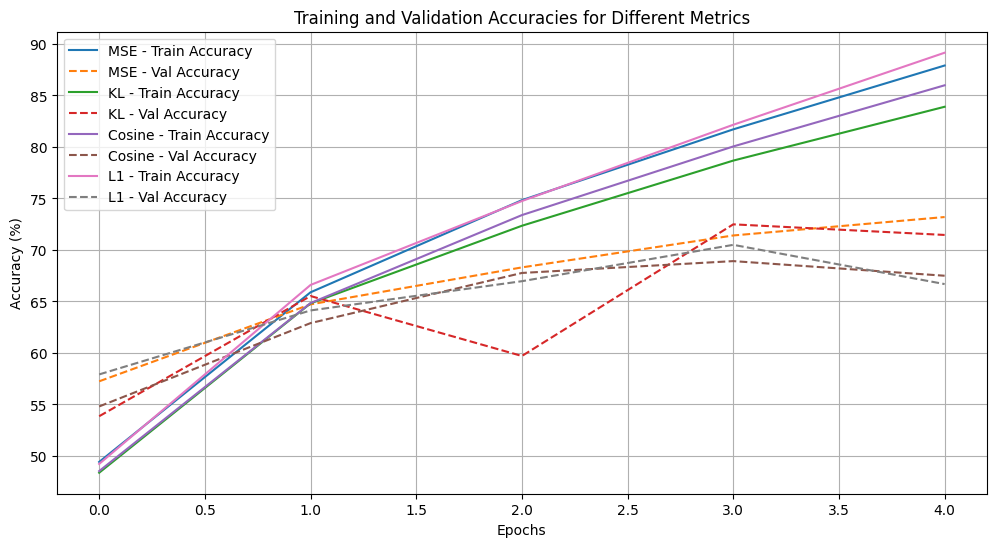

In [43]:
# Plot training and validation accuracies
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(results[metric]["train_acc"], label=f'{metric} - Train Accuracy')
    plt.plot(results[metric]["val_acc"], label=f'{metric} - Val Accuracy', linestyle='--')

plt.title("Training and Validation Accuracies for Different Metrics")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

I chose 4 metrics for comparison. The above plot shows the model's accuracy using 4 metrics after 5 epochs. MSE and KL metrics give better results than cosine and L1 metrics. And MSE gives a more stable result than the KL metric.

# Creating Custom Convolutional Neural Networks

## Custom Teacher Network

In [ ]:
class CustomTeacherNet(nn.Module):
    def __init__(self):
        super(CustomTeacherNet, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Input: (3, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (64, 16, 16)

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (128, 8, 8)

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (256, 4, 4)

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (512, 2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)  # Output: 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize the custom teacher network
custom_teacher_model = CustomTeacherNet()
print(custom_teacher_model)

CustomTeacherNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1)

## Custom Student Networks

In [ ]:
class CustomStudentNet(nn.Module):
    def __init__(self):
        super(CustomStudentNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)  # Output: 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize the custom student network
custom_student_model = CustomStudentNet()
print(custom_student_model)

CustomStudentNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 10, Repeat the steps of the first part using custom teacher network.

### Train the custom teacher network on CIFAR-10

In [ ]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match ResNet50 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Loading the CIFAR-10 dataset
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(cifar10_dataset))
val_size = len(cifar10_dataset) - train_size
train_dataset, val_dataset = random_split(cifar10_dataset, [train_size, val_size])

#Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
num_epochs = 10
learning_rate = 0.001
custom_teacher_model, best_teacher_acc = train(
    custom_teacher_model,
    train_loader,
    val_loader,
    epochs=num_epochs,
    learning_rate=learning_rate,
    device=device,
    name_model="best_custom_teacher_model.pth"
)

Epoch 1/10: 100%|██████████| 625/625 [00:20<00:00, 30.18it/s]

Epoch 1, Loss: 1.9473, Train Accuracy: 21.52%


Validation Accuracy: 29.60%
Best model saved.


Epoch 2/10: 100%|██████████| 625/625 [00:19<00:00, 32.03it/s]

Epoch 2, Loss: 1.5703, Train Accuracy: 38.60%


Validation Accuracy: 49.03%
Best model saved.


Epoch 3/10: 100%|██████████| 625/625 [00:18<00:00, 33.85it/s]

Epoch 3, Loss: 1.2481, Train Accuracy: 53.31%


Validation Accuracy: 58.98%
Best model saved.


Epoch 4/10: 100%|██████████| 625/625 [00:18<00:00, 33.06it/s]

Epoch 4, Loss: 1.0050, Train Accuracy: 64.28%


Validation Accuracy: 62.97%
Best model saved.


Epoch 5/10: 100%|██████████| 625/625 [00:19<00:00, 32.20it/s]

Epoch 5, Loss: 0.8376, Train Accuracy: 70.47%


Validation Accuracy: 71.08%
Best model saved.


Epoch 6/10: 100%|██████████| 625/625 [00:18<00:00, 33.35it/s]

Epoch 6, Loss: 0.7138, Train Accuracy: 74.88%


Validation Accuracy: 73.41%
Best model saved.


Epoch 7/10: 100%|██████████| 625/625 [00:18<00:00, 33.73it/s]

Epoch 7, Loss: 0.6135, Train Accuracy: 78.71%


Validation Accuracy: 75.63%
Best model saved.


Epoch 8/10: 100%|██████████| 625/625 [00:19<00:00, 32.27it/s]

Epoch 8, Loss: 0.5164, Train Accuracy: 82.18%


Validation Accuracy: 76.93%
Best model saved.


Epoch 9/10: 100%|██████████| 625/625 [00:18<00:00, 33.08it/s]

Epoch 9, Loss: 0.4354, Train Accuracy: 85.22%


Validation Accuracy: 78.66%
Best model saved.


Epoch 10/10: 100%|██████████| 625/625 [00:18<00:00, 33.55it/s]

Epoch 10, Loss: 0.3666, Train Accuracy: 87.61%


Validation Accuracy: 80.36%
Best model saved.


In [ ]:
test_accuracy = validate(custom_teacher_model, test_loader, device)
print(f"Test accuracy of custom teacher model: {test_accuracy:.2f}%")

Test accuracy of custom teacher model: 80.07%


### Train custom student network without teacher supervision

In [ ]:
trained_student, best_student_acc = train(
    custom_student_model,
    train_loader,
    val_loader,
    epochs=num_epochs,
    learning_rate=learning_rate,
    device=device,
    name_model="best_custom_student_model.pth"
)

Epoch 1/10: 100%|██████████| 625/625 [00:13<00:00, 44.68it/s]

Epoch 1, Loss: 1.4261, Train Accuracy: 48.29%


Validation Accuracy: 63.32%
Best model saved.


Epoch 2/10: 100%|██████████| 625/625 [00:13<00:00, 44.95it/s]

Epoch 2, Loss: 0.8486, Train Accuracy: 70.11%


Validation Accuracy: 72.82%
Best model saved.


Epoch 3/10: 100%|██████████| 625/625 [00:14<00:00, 44.50it/s]

Epoch 3, Loss: 0.5830, Train Accuracy: 79.58%


Validation Accuracy: 76.20%
Best model saved.


Epoch 4/10: 100%|██████████| 625/625 [00:14<00:00, 44.30it/s]

Epoch 4, Loss: 0.3616, Train Accuracy: 87.40%


Validation Accuracy: 76.06%


Epoch 5/10: 100%|██████████| 625/625 [00:14<00:00, 44.47it/s]

Epoch 5, Loss: 0.1821, Train Accuracy: 93.80%


Validation Accuracy: 76.08%


Epoch 6/10: 100%|██████████| 625/625 [00:14<00:00, 43.96it/s]

Epoch 6, Loss: 0.1162, Train Accuracy: 96.02%


Validation Accuracy: 76.07%


Epoch 7/10: 100%|██████████| 625/625 [00:14<00:00, 44.59it/s]

Epoch 7, Loss: 0.0818, Train Accuracy: 97.15%


Validation Accuracy: 75.18%


Epoch 8/10: 100%|██████████| 625/625 [00:13<00:00, 44.95it/s]

Epoch 8, Loss: 0.0742, Train Accuracy: 97.55%


Validation Accuracy: 75.73%


Epoch 9/10: 100%|██████████| 625/625 [00:14<00:00, 44.40it/s]

Epoch 9, Loss: 0.0651, Train Accuracy: 97.91%


Validation Accuracy: 75.10%


Epoch 10/10: 100%|██████████| 625/625 [00:13<00:00, 44.93it/s]

Epoch 10, Loss: 0.0655, Train Accuracy: 97.86%


Validation Accuracy: 75.35%


In [ ]:
test_accuracy = validate(trained_student, test_loader, device)
print(f"Test accuracy of custom student model without knowledge distillation: {test_accuracy:.2f}%")

Test accuracy of custom student model without knowledge distillation: 74.81%


### Train custom student model with Knowledge Distillation at score level

In [ ]:
# Initialize custom student model
custom_student_model = CustomStudentNet()

# Train student model using knowledge distillation at scores level
trained_student_kd, best_student_kd_acc = train_with_distillation(
    student_model=custom_student_model,
    teacher_model=custom_teacher_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)

Epoch 1/10: 100%|██████████| 625/625 [00:20<00:00, 30.47it/s, loss=2.03]


Epoch 1, Loss: 2.3183, Train Accuracy: 50.88%
Validation Accuracy: 65.16%
Best distilled student model saved.


Epoch 2/10: 100%|██████████| 625/625 [00:18<00:00, 33.06it/s, loss=0.89]

Epoch 2, Loss: 1.1220, Train Accuracy: 71.69%


Validation Accuracy: 74.65%
Best distilled student model saved.


Epoch 3/10: 100%|██████████| 625/625 [00:18<00:00, 33.66it/s, loss=0.7]

Epoch 3, Loss: 0.7406, Train Accuracy: 80.25%


Validation Accuracy: 78.78%
Best distilled student model saved.


Epoch 4/10: 100%|██████████| 625/625 [00:19<00:00, 32.10it/s, loss=0.543]

Epoch 4, Loss: 0.5281, Train Accuracy: 86.14%


Validation Accuracy: 79.50%
Best distilled student model saved.


Epoch 5/10: 100%|██████████| 625/625 [00:18<00:00, 33.01it/s, loss=0.401]

Epoch 5, Loss: 0.3752, Train Accuracy: 91.07%


Validation Accuracy: 80.74%
Best distilled student model saved.


Epoch 6/10: 100%|██████████| 625/625 [00:20<00:00, 30.70it/s, loss=0.276]

Epoch 6, Loss: 0.2851, Train Accuracy: 94.73%


Validation Accuracy: 81.00%
Best distilled student model saved.


Epoch 7/10: 100%|██████████| 625/625 [00:19<00:00, 32.66it/s, loss=0.309]

Epoch 7, Loss: 0.2290, Train Accuracy: 96.64%


Validation Accuracy: 80.52%


Epoch 8/10: 100%|██████████| 625/625 [00:19<00:00, 31.31it/s, loss=0.177]

Epoch 8, Loss: 0.2040, Train Accuracy: 97.44%


Validation Accuracy: 81.03%
Best distilled student model saved.


Epoch 9/10: 100%|██████████| 625/625 [00:19<00:00, 31.87it/s, loss=0.194]

Epoch 9, Loss: 0.1939, Train Accuracy: 97.61%


Validation Accuracy: 81.06%
Best distilled student model saved.


Epoch 10/10: 100%|██████████| 625/625 [00:21<00:00, 28.94it/s, loss=0.256]

Epoch 10, Loss: 0.1889, Train Accuracy: 97.79%


Validation Accuracy: 80.95%


In [ ]:
test_accuracy = validate(trained_student_kd, test_loader, device)
print(f"Test accuracy of custom student model with knowledge distillation at score level: {test_accuracy:.2f}%")

Test accuracy of custom student model with knowledge distillation at score level: 80.56%


### Train custom student model with Knowledge Distillation at Scores and Feature Maps

In [ ]:
for name, module in custom_teacher_model.named_modules():
    print(name, module)

 CustomTeacherNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1

In [ ]:
# Initialize custom student model
custom_student_model = CustomStudentNet()

trained_student_kd_features, best_student_kd_features_acc = train_with_feature_distillation(
    student_model=custom_student_model,
    teacher_model=custom_teacher_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=num_epochs,
    learning_rate=learning_rate,
    device=device,
    teacher_layer="features.7",
    student_layer="features.7"
)

Epoch 1/10: 100%|██████████| 625/625 [00:21<00:00, 29.65it/s, loss=12.8]

Epoch 1, Loss: 13.5590, Train Accuracy: 50.98%


Validation Accuracy: 66.59%
Best distilled student model with features saved.


Epoch 2/10: 100%|██████████| 625/625 [00:21<00:00, 28.79it/s, loss=10.2]

Epoch 2, Loss: 12.3306, Train Accuracy: 69.98%


Validation Accuracy: 74.14%
Best distilled student model with features saved.


Epoch 3/10: 100%|██████████| 625/625 [00:19<00:00, 31.67it/s, loss=12.3]

Epoch 3, Loss: 11.9927, Train Accuracy: 76.67%


Validation Accuracy: 77.22%
Best distilled student model with features saved.


Epoch 4/10: 100%|██████████| 625/625 [00:19<00:00, 31.44it/s, loss=9.7]

Epoch 4, Loss: 11.8424, Train Accuracy: 80.58%


Validation Accuracy: 78.96%
Best distilled student model with features saved.


Epoch 5/10: 100%|██████████| 625/625 [00:20<00:00, 29.86it/s, loss=11.1]

Epoch 5, Loss: 11.6803, Train Accuracy: 83.66%


Validation Accuracy: 79.79%
Best distilled student model with features saved.


Epoch 6/10: 100%|██████████| 625/625 [00:20<00:00, 30.35it/s, loss=12.3]

Epoch 6, Loss: 11.5768, Train Accuracy: 86.12%


Validation Accuracy: 80.50%
Best distilled student model with features saved.


Epoch 7/10: 100%|██████████| 625/625 [00:19<00:00, 31.64it/s, loss=12.9]

Epoch 7, Loss: 11.5293, Train Accuracy: 87.89%


Validation Accuracy: 79.92%


Epoch 8/10: 100%|██████████| 625/625 [00:20<00:00, 31.07it/s, loss=12.2]

Epoch 8, Loss: 11.4858, Train Accuracy: 89.86%


Validation Accuracy: 80.87%
Best distilled student model with features saved.


Epoch 9/10: 100%|██████████| 625/625 [00:20<00:00, 29.81it/s, loss=11.8]

Epoch 9, Loss: 11.4212, Train Accuracy: 90.96%


Validation Accuracy: 81.17%
Best distilled student model with features saved.


Epoch 10/10: 100%|██████████| 625/625 [00:20<00:00, 30.82it/s, loss=10.7]

Epoch 10, Loss: 11.4232, Train Accuracy: 92.03%


Validation Accuracy: 81.42%
Best distilled student model with features saved.


In [ ]:
test_accuracy = validate(trained_student_kd_features, test_loader, device)
print(f"Test accuracy of custom student model with knowledge distillation at score and features map: {test_accuracy:.2f}%")

Test accuracy of custom student model with knowledge distillation at score and features map: 80.29%


### Comparison

I also use the number of epochs equal to 10 and the learning rate equal to 0.0001 for comparison.

In [17]:
# Data for the comparison table
data = {
    "Model": [
        "Custom Teacher Model",
        "Student Model (No KD)",
        "Student Model (KD, Score Level)",
        "Student Model (KD, Score + Feature Map)"
    ],
    "Validation Accuracy (%)": [80.36, 75.35, 80.95, 81.40]
}

# Create the DataFrame
df = pd.DataFrame(data)
display(df)

,Model,Validation Accuracy (%)
0,Custom Teacher Model,80.36
1,Student Model (No KD),75.35
2,"Student Model (KD, Score Level)",80.95
3,"Student Model (KD, Score + Feature Map)",81.40


**Interpretation of the results**

The custom teacher model achieves a validation accuracy of 80.36%, which serves as the benchmark for the student's performance.

The student model trained from scratch (without KD) achieves a validation accuracy of 75.35%, significantly lower than the teacher.

With KD at the score level, the student achieves a validation accuracy of 80.95%, surpassing the teacher's performance. This demonstrates the effectiveness of soft-label guidance from the teacher in helping the student learn better representations.

Adding feature map-level distillation further improves the student's validation accuracy to 81.40%, the highest among all models. This indicates that feature map alignment provides additional benefits by guiding the student to mimic intermediate teacher representations.